In [1]:
#importazione del df
import pandas as pd
df = pd.read_csv('csv/decessi_tot.csv')
df.head()

,Data,Totale
0,2015-01-01,2632
1,2015-01-02,2182
2,2015-01-03,2215
3,2015-01-04,2264
4,2015-01-05,2301


In [2]:
#trasformo le date e i numeri
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
df.Totale = pd.to_numeric(df.Totale)
df.head()

,Data,Totale
0,2015-01-01,2632
1,2015-01-02,2182
2,2015-01-03,2215
3,2015-01-04,2264
4,2015-01-05,2301


In [3]:
#metto il campo 'Data' come indice
df=df.set_index('Data')
df.head()

,Totale
Data,
2015-01-01,2632
2015-01-02,2182
2015-01-03,2215
2015-01-04,2264
2015-01-05,2301


In [4]:
#creo la time series
ts = df.Totale
ts

Data
2015-01-01    2632
2015-01-02    2182
2015-01-03    2215
2015-01-04    2264
2015-01-05    2301
              ... 
2020-04-26    1735
2020-04-27    1752
2020-04-28    1702
2020-04-29    1664
2020-04-30    1539
Name: Totale, Length: 1947, dtype: int64

In [5]:
from datetime import datetime
from datetime import timedelta
start_date = datetime(2015,1,1)
end_date = datetime(2020,4,30)
lim_ts = ts[start_date:end_date]

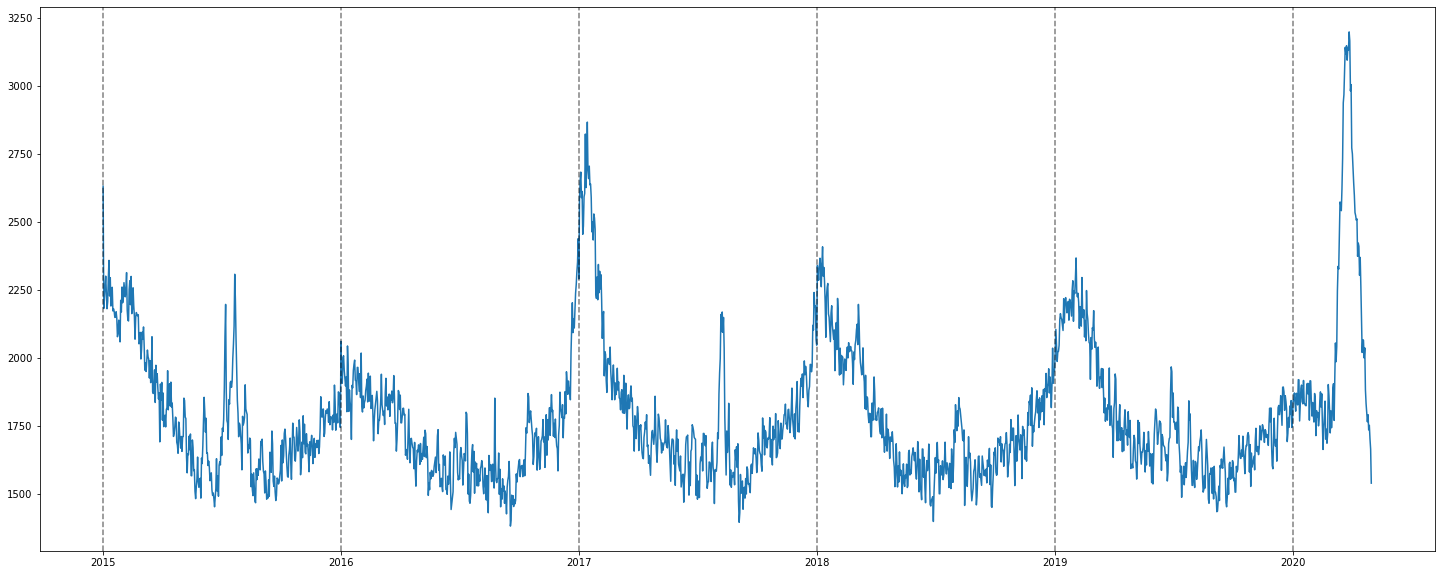

In [6]:
#visulizzo il grafico della time series
import matplotlib.pyplot as plt
plt.figure(figsize=(25,10))
plt.plot(lim_ts)
for year in range(start_date.year,end_date.year+1):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)

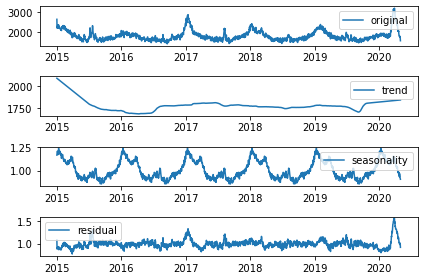

In [7]:
#decomposizione della serie in trend, stagionalità e residui
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts, period=365, two_sided=True, extrapolate_trend=1, model='multiplicative')

ts_trend = decomposition.trend #andamento della curva
ts_seasonal = decomposition.seasonal #stagionalità 
ts_residual = decomposition.resid #parti rimanenti
plt.subplot(411)
plt.plot(ts,label='original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(ts_trend,label='trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(ts_seasonal,label='seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(ts_residual,label='residual')
plt.legend(loc='best')
plt.tight_layout()

In [8]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=365).mean()
    rolstd = timeseries.rolling(window=365).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    critical_value = dftest[4]['5%']
    test_statistic = dftest[0]
    alpha = 1e-3
    pvalue = dftest[1]
    if pvalue < alpha and test_statistic < critical_value:  # null hypothesis: x is non stationary
        print("X is stationary")
    else:
        print("X is not stationary")

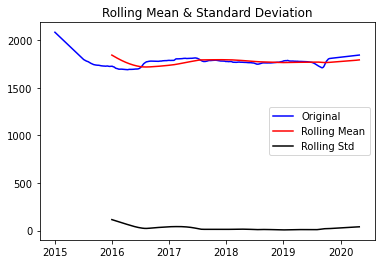

Results of Dickey-Fuller Test:
Test Statistic                  -21.896883
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1946.000000
Critical Value (1%)              -3.433715
Critical Value (5%)              -2.863026
Critical Value (10%)             -2.567561
dtype: float64
X is stationary


In [9]:
#verifico che il trend sia stazionario
test_stationarity(ts_trend.dropna())

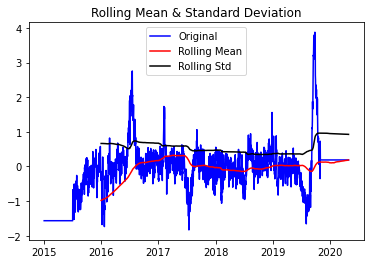

Results of Dickey-Fuller Test:
Test Statistic                   -4.979763
p-value                           0.000024
#Lags Used                       22.000000
Number of Observations Used    1923.000000
Critical Value (1%)              -3.433755
Critical Value (5%)              -2.863044
Critical Value (10%)             -2.567571
dtype: float64
X is stationary


In [10]:
#rendo il trend stazionario con l'operazione di differenzazione
ts_trend_diff = ts_trend.diff()
test_stationarity(ts_trend_diff.dropna())

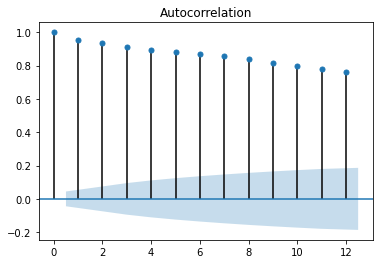

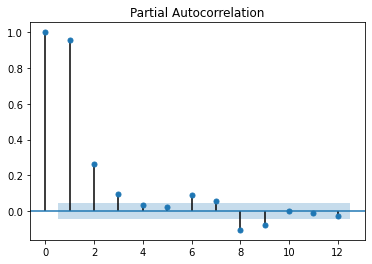

In [11]:
#grafici di autocorrelazione e autocorrelazione parziale
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts, lags =12)
plot_pacf(ts, lags =12)
plt.show()

In [12]:
#suddivisione del trend della serie in train e test
from datetime import datetime
train_end = datetime(2019,10,31)
test_end = datetime (2019,12,31)
covid_end = datetime(2020,4,30)

train = ts_trend[:train_end]
test = ts_trend[train_end + timedelta(days=1): test_end]

#trend COVID?
trend_covid = ts_trend[test_end + timedelta(days=1): covid_end]

#print(len(train))
#print(len(test))
#ts_trend
#print(len(covid))


In [13]:
train

Data
2015-01-01    2082.515068
2015-01-02    2080.950685
2015-01-03    2079.386301
2015-01-04    2077.821918
2015-01-05    2076.257534
                 ...     
2019-10-27    1807.487671
2019-10-28    1807.904110
2019-10-29    1808.158904
2019-10-30    1808.347945
2019-10-31    1807.997260
Name: trend, Length: 1765, dtype: float64

In [57]:
#creazione del modello
from statsmodels.tsa.statespace.sarimax import SARIMAX

p = 12
d = 1
q = 9

model = SARIMAX(train, order=(p, d, q))
model_fit = model.fit(disp=1,solver='powell')
print(model_fit.summary())

c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


                               SARIMAX Results                                
Dep. Variable:                  trend   No. Observations:                 1765
Model:              SARIMAX(12, 1, 9)   Log Likelihood                 -72.710
Date:                Mon, 17 Aug 2020   AIC                            189.420
Time:                        17:46:48   BIC                            309.877
Sample:                    01-01-2015   HQIC                           233.931
                         - 10-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6122      0.133      4.604      0.000       0.352       0.873
ar.L2          1.1225      0.077     14.559      0.000       0.971       1.274
ar.L3         -0.4844      0.102     -4.749      0.0

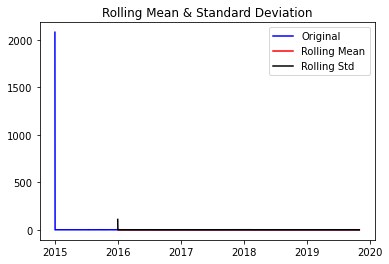

Results of Dickey-Fuller Test:
Test Statistic                  -24.695446
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    1761.000000
Critical Value (1%)              -3.434069
Critical Value (5%)              -2.863183
Critical Value (10%)             -2.567645
dtype: float64
X is stationary


In [58]:
#verifico che i residui della serie siano stazionari
residuals = model_fit.resid
test_stationarity(residuals)

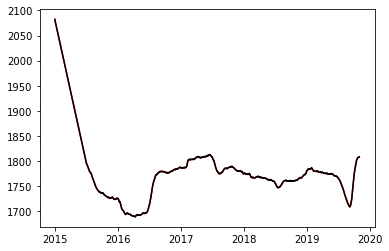

In [59]:
#verifico che il risultato del modello sul train
plt.plot(train.iloc[1:], color='red')
plt.plot(model_fit.fittedvalues.iloc[1:],color='black')
plt.show()

In [60]:
model_fit.fittedvalues #valori del modello 

Data
2015-01-01       0.000000
2015-01-02    2082.516941
2015-01-03    2079.452366
2015-01-04    2077.868498
2015-01-05    2076.298757
                 ...     
2019-10-27    1807.272703
2019-10-28    1808.001541
2019-10-29    1808.279898
2019-10-30    1808.469156
2019-10-31    1808.518676
Length: 1765, dtype: float64

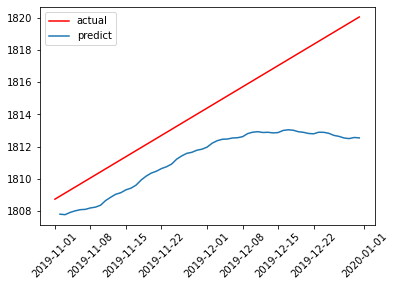

In [61]:
# predizioni sul test set
predictions = model_fit.forecast(steps=len(test))
plt.plot(test, color='red', label='actual')
plt.plot(predictions.iloc[1:], label='predict')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [62]:
#calcolo RMSE
import numpy as np
from statsmodels.tools.eval_measures import rmse
nrmse = rmse(predictions, test)/(np.max(test)-np.min(test))
print('RMSE = ', nrmse)

RMSE =  0.3249907335766762


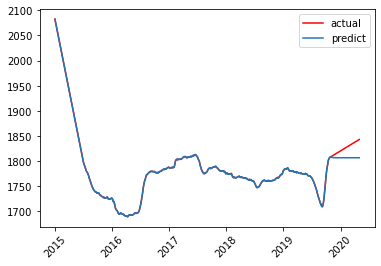

In [29]:
# predizione sul trend della serie storica includendo il 2020
predictions_trend = model_fit.predict(start=0, end=len(ts_trend.iloc[:-1]))
plt.plot(ts_trend, color='red', label='actual')
plt.plot(predictions_trend.iloc[1:], label='predict')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [30]:
ts_trend

Data
2015-01-01    2082.515068
2015-01-02    2080.950685
2015-01-03    2079.386301
2015-01-04    2077.821918
2015-01-05    2076.257534
                 ...     
2020-04-26    1842.186301
2020-04-27    1842.375342
2020-04-28    1842.564384
2020-04-29    1842.753425
2020-04-30    1842.942466
Name: trend, Length: 1947, dtype: float64

In [31]:
covid_predictions = predictions_trend.iloc[1826:] #valori della previsione del periodo covid (dal 01-01-2020 al 30-04-2020)

In [32]:
covid_predictions

2020-01-01    1806.591933
2020-01-02    1806.623861
2020-01-03    1806.649487
2020-01-04    1806.587812
2020-01-05    1806.571090
                 ...     
2020-04-26    1806.568152
2020-04-27    1806.619318
2020-04-28    1806.618084
2020-04-29    1806.570667
2020-04-30    1806.581847
Freq: D, Length: 121, dtype: float64

In [33]:
trend_covid

Data
2020-01-01    1820.257534
2020-01-02    1820.446575
2020-01-03    1820.635616
2020-01-04    1820.824658
2020-01-05    1821.013699
                 ...     
2020-04-26    1842.186301
2020-04-27    1842.375342
2020-04-28    1842.564384
2020-04-29    1842.753425
2020-04-30    1842.942466
Name: trend, Length: 121, dtype: float64

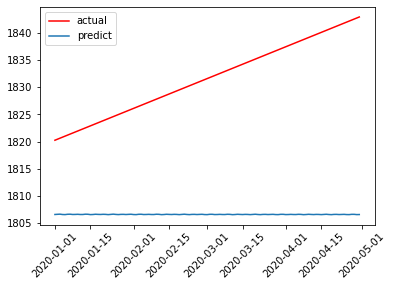

In [34]:
#previsione periodo covid
plt.plot(trend_covid, label='actual', color='red')
plt.plot(covid_predictions, label='predict')
plt.xticks(rotation=45)
plt.legend()
plt.show()

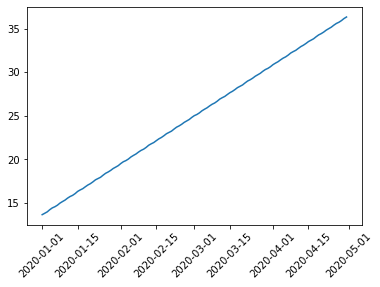

In [35]:
#calcolo della differenza tra i valori reali del covid e la previsione (periodo di riferimento 01-01-2020 - 30-04-2020)
trend_covid_diff = (trend_covid - covid_predictions)
trend_covid = trend_covid_diff.dropna()
plt.plot(trend_covid_diff)
plt.xticks(rotation=45)
plt.show()

In [36]:
trend_covid_diff #differenza tra i valori del trend_covid e la previsione

Data
2020-01-01    13.665601
2020-01-02    13.822714
2020-01-03    13.986130
2020-01-04    14.236845
2020-01-05    14.442609
                ...    
2020-04-26    35.618149
2020-04-27    35.756025
2020-04-28    35.946300
2020-04-29    36.182758
2020-04-30    36.360619
Length: 121, dtype: float64

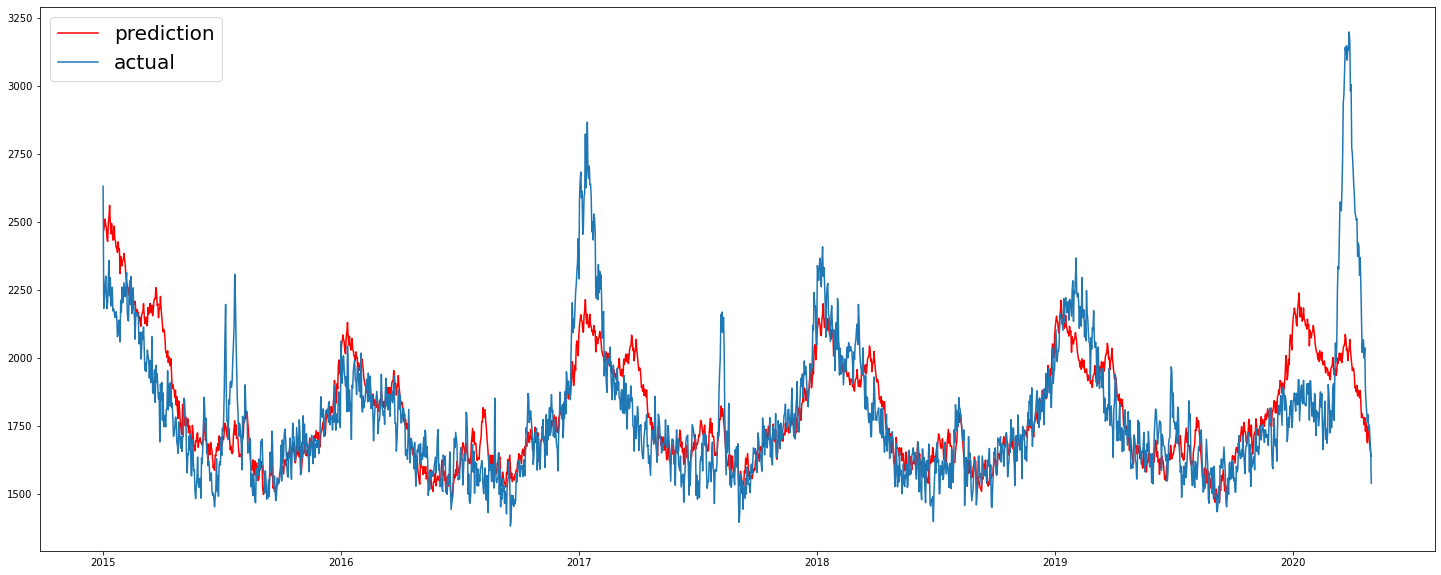

In [37]:
predictions_tot = predictions_trend.iloc[1:] * ts_seasonal
plt.figure(figsize=(25,10))
plt.plot(predictions_tot, color='red', label='prediction')
plt.plot(ts, label='actual')
plt.legend(prop={'size': 20})
plt.show()

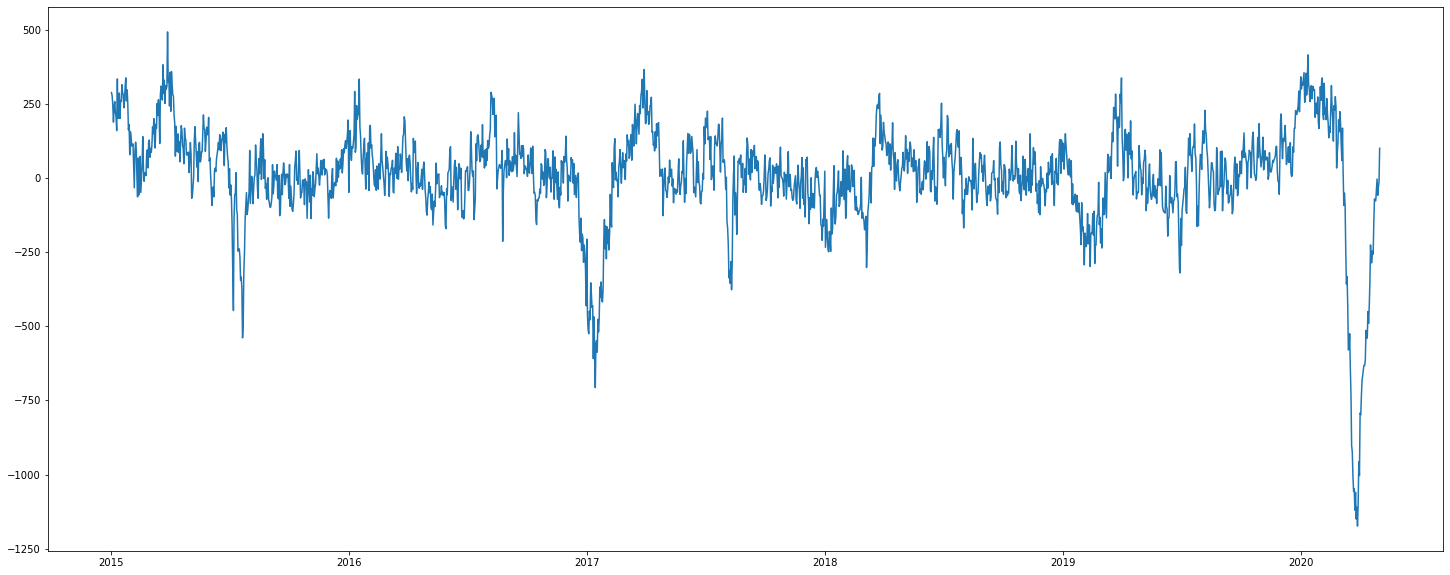

In [38]:
diff_predictions_tot = (predictions_tot - ts)
plt.figure(figsize=(25,10))
plt.plot(diff_predictions_tot)
plt.show()

In [133]:
predictions_tot.to_csv('csv/predictions_daily.csv')